# Random Forest

w207 section 3 - Ben Meier

## Import modules, set parameters

In [1]:
import os
import random
import math

import numpy as np
import pandas as pd
from google.colab import drive, files

import matplotlib.pyplot as plt

# Set options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)


In [2]:
try:
    import tensorflow_decision_forests as tfdf
    from tensorflow_decision_forests import keras
    import wurlitzer

except:
    !pip install tensorflow_decision_forests
    !pip install wurlitzer
    import tensorflow_decision_forests as tfdf
    from tensorflow_decision_forests import keras
    import wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 29.3 MB/s 
     |████████████████████████████████| 511.7 MB 6.5 kB/s 
     |████████████████████████████████| 438 kB 65.8 MB/s 
     |████████████████████████████████| 5.8 MB 58.2 MB/s 
     |████████████████████████████████| 1.6 MB 55.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Unin

In [3]:
try:
    import sweetviz
except:
    !pip install sweetviz
    import sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.1 MB 30.5 MB/s 


In [4]:
# Connect notebook to google drive W207 - Final Project Folder
drive.mount('/content/drive')

# Numpy random seed
np.random.seed(10)

Mounted at /content/drive


## Import data

In [5]:
path = r'/content/drive/MyDrive/W207 - Final Project/'
path_pickles = path + 'pickles/'

df_np_train = pd.read_pickle(path_pickles + 'dffinal_no_preprocess_train.pk1')
df_np_test = pd.read_pickle(path_pickles + 'dffinal_no_preprocess_test.pk1')

df_mh_train = pd.read_pickle(path_pickles + 'dffinal_multihot_train.pk1')
df_mh_test = pd.read_pickle(path_pickles + 'dffinal_multihot_test.pk1')

print("No proprocess: \n train:", df_np_train.shape[0], "test:", df_np_test.shape[0])

print("Multihot: \n train:", df_mh_train.shape[0], "test:", df_mh_test.shape[0])

No proprocess: 
 train: 187002 test: 109063
Multihot: 
 train: 187002 test: 109063


In [6]:
df_np_train.sample(5)

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,facility_type_consol,cooling_consol,heating_consol,wt_consol
243492,0.059318,nycOrdinance,4068090001,2014.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,540916.0,2004.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.400000,147.60000,NaN,"Flushing, NY 11367",Multifamily,NaN,NaN,NaN
19208,0.838074,calBEBP,6835880,2018.0,3B Warm - Dry (El Paso-TX),Commercial,Warehouse - Self-storage,67170.0,1984.0,NaN,NaN,NaN,NaN,NaN,NaN,Not Labeled,NaN,2.521560,0.910278,3.431838,8.87349,0.215506,"Oceanside, CA 92054",Industrial,NaN,NaN,NaN
90338,0.062870,gainesville,140959,2010.0,2A Hot - Humid (Houston-TX),Residential,NaN,2298.0,1987.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,25.320335,NaN,NaN,NaN,NaN,"Gainesville, FL 32608",NaN,Central AC,NaN,NaN
80028,0.330825,gainesville,138357,2013.0,2A Hot - Humid (Houston-TX),Residential,NaN,1128.0,1978.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,24.085176,NaN,NaN,NaN,NaN,"Gainesville, FL 32608",NaN,Central AC,NaN,NaN
236425,0.322726,nycOrdinance,3086907501,2012.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,107519.0,1929.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.216957,NaN,NaN,"Brooklyn, NY 11235",Multifamily,NaN,NaN,NaN


## Define Functions

In [7]:
# TFDF set cell height
from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

### Preprocess 1
**Assumptions**
1. Keep most recent year for each building
2. Drop rows with NaN target feature

In [8]:
def preprocess1(dfin, target, keep_cols = [], drop_cols = []):
    # Drop rows with site_eui or source_eui
    df = dfin.loc[(~dfin[target].isna()), :].copy()
    
    # Take most recent year for each building
    keep_rows = (df.groupby(['datasource','id']).max('year')
        .reset_index()[['datasource', 'id', 'year']])
    df2 = df.merge(keep_rows, 
                   how='inner', 
                   on=['datasource', 'id', 'year'], 
                   validate='1:1')

    # Specify Columns
    if len(keep_cols) == 0:
        keep_cols = dfin.columns

    if target not in keep_cols:
        keep_cols.append(target)

    cols = [col for col in keep_cols if (col not in drop_cols) and (col in df2.columns)]
    df3 = df2.loc[:, cols]

    print("Shape", df3.shape)
    return df3

## EDA

### SweetViz

In [9]:
# Preprocess for visualization
target = 'site_eui'
drop = ['id', 'electric_eui', 'fuel_eui', 'source_eui', 'ghg_emissions_int']
keep = df_np_train.columns
print("keep:", keep)
train =  preprocess1(df_np_train, target, keep_cols=keep, drop_cols=drop)
test = preprocess1(df_np_test, target, keep_cols=keep, drop_cols=drop)
train.sample(5)

keep: Index(['rand_num', 'datasource', 'id', 'year', 'climate', 'building_class',
       'facility_type', 'floor_area', 'year_built', 'heating', 'cooling',
       'wall_type', 'roof_ceiling', 'window_glass_layers', 'window_glass_type',
       'energy_star_label', 'energy_star_rating', 'electric_eui', 'fuel_eui',
       'site_eui', 'source_eui', 'ghg_emissions_int', 'city_line',
       'facility_type_consol', 'cooling_consol', 'heating_consol',
       'wt_consol'],
      dtype='object')
Shape (42274, 22)
Shape (18845, 22)


,rand_num,datasource,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,site_eui,city_line,facility_type_consol,cooling_consol,heating_consol,wt_consol
19834,0.418721,gainesville,2012.0,2A Hot - Humid (Houston-TX),Residential,NaN,1045.0,1968.0,NaN,NaN,NaN,Built-up,NaN,NaN,NaN,NaN,44.795393,"Gainesville, FL 32641",NaN,NaN,NaN,NaN
28100,0.122425,nycOrdinance,2017.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,52245.0,1939.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,127.700000,"Bronx, NY 10457",Multifamily,NaN,NaN,NaN
4472,0.694584,calBEBP,2018.0,3B Warm - Dry (El Paso-TX),Commercial,Office - Uncategorized,449084.0,1973.0,NaN,NaN,NaN,NaN,NaN,NaN,Not Labeled,93.0,30.249583,"Glendale, CA 91203",Office,NaN,NaN,NaN
27802,0.213656,nycOrdinance,2017.0,4A Mixed - Humid (Baltimore-MD),Residential,Multifamily - Uncategorized,44735.0,1920.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,148.700000,"Bronx, NY 10454",Multifamily,NaN,NaN,NaN
6790,0.562102,calProp,2013.0,3B Warm - Dry (El Paso-TX),Commercial,Education - Uncategorized,39729.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.553384,"San Bernardino, CA 92405",Office,NaN,NaN,NaN


In [10]:
path_rpt = path + 'output_ben/No_preprocess Report.html'
rpt  = sweetviz.compare(
    [train, "Training"],
    [test, "Test"],
    target_feat=target)
rpt.show_html(path_rpt)

files.download(path_rpt)

                                             |          | [  0%]   00:00 -> (? left)

Report /content/drive/MyDrive/W207 - Final Project/output_ben/No_preprocess Report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Feature Engineering

### 'Binarize' Building class

In [11]:
df_np_train.building_class.drop_duplicates()

0    Residential
4     Commercial
Name: building_class, dtype: object

In [12]:
repl = {'Residential': 1.0,
        'Commercial': 0.0}
df_np_train['is_residential'] = df_np_train.building_class.replace(repl)
df_np_test['is_residential'] = df_np_test.building_class.replace(repl)

df_np_train[['is_residential', 'building_class']].drop_duplicates()

,is_residential,building_class
0,1.0,Residential
4,0.0,Commercial


### Separate Climate

In [13]:
def split_climate(dfin):
        
    fn = lambda x: x.split(" - ")[1].split(" ")[0] if isinstance(x, str) else np.NaN
    dfin['dryness'] = dfin.climate.apply(fn)

    fn = lambda x: x.split(" - ")[0].split(" ")[1] if isinstance(x, str) else np.NaN
    dfin['temp'] = dfin.climate.apply(fn)

    return dfin    

In [14]:
df_engr_train = split_climate(df_np_train)
df_engr_test = split_climate(df_np_test)

## Identify Features of Interest

Column to predict:
- site_eui

Features:
- dryness
- temp
- Building class
- Facility type (medium missing values)
- Floor area
- Year built (low missing)
- city_line (low missing)
- facility_type (not consolidated)
- cooling_consol
- heating_consol

In [15]:
# Possible features of interest:
target_feature_cols = ['electric_eui', 'fuel_eui', 'site_eui', 
                    'source_eui', 'ghg_emissions_int']

df_engr_train[target_feature_cols].corr()

,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int
electric_eui,1.000000,0.271798,0.764887,0.945095,0.833857
fuel_eui,0.271798,1.000000,0.828547,0.568817,0.648212
site_eui,0.764887,0.828547,1.000000,0.910922,0.923837
source_eui,0.945095,0.568817,0.910922,1.000000,0.936075
ghg_emissions_int,0.833857,0.648212,0.923837,0.936075,1.000000


In [16]:
df_engr_train.head()

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,facility_type_consol,cooling_consol,heating_consol,wt_consol,is_residential,dryness,temp
0,0.548814,austin,100012,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.656706,0.0,28.656706,89.982058,3.565981,"Austin, TX 78704",Multifamily,NaN,NaN,NaN,1.0,Humid,Hot
1,0.715189,austin,100012,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.493681,0.0,29.493681,92.610158,3.670133,"Austin, TX 78704",Multifamily,NaN,NaN,NaN,1.0,Humid,Hot
2,0.602763,austin,100030,2018.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,37.971292,0.0,37.971292,119.229858,4.725069,"Austin, TX 78704",Multifamily,NaN,NaN,NaN,1.0,Humid,Hot
3,0.544883,austin,100030,2019.0,2A Hot - Humid (Houston-TX),Residential,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,39.017660,0.0,39.017660,122.515452,4.855277,"Austin, TX 78704",Multifamily,NaN,NaN,NaN,1.0,Humid,Hot
4,0.423655,austin,100138,2014.0,2A Hot - Humid (Houston-TX),Commercial,NaN,62368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94.0,32.005873,NaN,NaN,NaN,NaN,"Austin, TX 78704",NaN,NaN,NaN,NaN,0.0,Humid,Hot


# Baseline model 
## linear regression

Predict site_eui and drop any rows that have missing data. Dataset goes from 187k to 55k rows.

In [17]:
# Identify continuous variables
cols = ['site_eui', 'year', 'floor_area', 'year_built', 
        'energy_star_rating', 'is_residential']
df_simple_train = df_engr_train[cols]
print("shape:", df_simple_train.shape)

shape: (187002, 6)


In [18]:
# Deal with NANs
print(df_simple_train.dropna(axis=0).shape)
df_simple_train = df_simple_train.dropna(axis=0)
X_simple_train = df_simple_train[cols].drop(columns=['site_eui']).copy()
y_simple_train = df_simple_train[['site_eui']].copy()
X_simple_train

(54900, 6)


,year,floor_area,year_built,energy_star_rating,is_residential
8806,2016.0,193230.0,1974.0,64.0,0.0
8816,2015.0,873348.0,1900.0,100.0,1.0
8817,2016.0,873348.0,1900.0,100.0,1.0
8819,2016.0,28637.0,1958.0,87.0,0.0
8820,2014.0,121101.0,1960.0,71.0,0.0
...,...,...,...,...,...
296060,2018.0,69230.0,1961.0,27.0,0.0
296061,2019.0,69230.0,1961.0,78.0,0.0
296062,2020.0,69230.0,1961.0,75.0,0.0
296063,2019.0,50163.0,1963.0,66.0,0.0


In [19]:
df_simple_train.describe()

,site_eui,year,floor_area,year_built,energy_star_rating,is_residential
count,54900.000000,54900.000000,5.490000e+04,54900.000000,54900.000000,54900.000000
mean,77.118628,2016.273169,1.647484e+05,1958.951093,61.330692,0.520692
std,54.027370,1.793611,2.348884e+05,35.097792,29.079307,0.499576
min,1.002998,2010.000000,1.560000e+03,1649.000000,1.000000,0.000000
25%,48.025450,2015.000000,5.700000e+04,1928.000000,39.000000,0.000000
50%,69.727666,2016.000000,9.027950e+04,1962.000000,67.000000,1.000000
75%,92.770091,2017.000000,1.741860e+05,1989.000000,86.000000,1.000000
max,983.844462,2020.000000,3.912529e+06,2019.000000,100.000000,1.000000


In [20]:
import tensorflow as tf
from tensorflow import keras

def build_model(num_features):
    """Return a simple linear regression model using the Keras Sequential API."""
    # Clear session and set a random seed for consistent behavior.
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    # Use Keras Sequential API to build a linear regression model.
    model = keras.Sequential()
    model.add(keras.layers.Dense(
      input_shape=[num_features], # each input has num_features features
      units=1,                    # there is a single output
      use_bias=True,               # include a learned bias parameter
      ))
  
    # Use mean squared error as our loss and the Adam optimizer.
    model.compile(loss='mse', optimizer='Adam', metrics=['mae', 'mape'])
    return model

model = build_model(num_features=X_simple_train.shape[1])

history = model.fit(x=X_simple_train, y=y_simple_train,
          validation_split=0.1, batch_size=12, epochs=40)

Epoch 1/40
4118/4118 [==============================] - 15s 3ms/step - loss: 3130450944.0000 - mae: 17678.8789 - mape: 34077.4531 - val_loss: 2740084.7500 - val_mae: 1550.4785 - val_mape: 3067.5981
Epoch 2/40
4118/4118 [==============================] - 13s 3ms/step - loss: 1046408.4375 - mae: 790.5745 - mape: 1801.1982 - val_loss: 6566.9458 - val_mae: 69.0907 - val_mape: 161.6904
Epoch 3/40
4118/4118 [==============================] - 15s 4ms/step - loss: 3885.6895 - mae: 41.8147 - mape: 112.6707 - val_loss: 2491.2869 - val_mae: 33.8401 - val_mape: 78.2590
Epoch 4/40
4118/4118 [==============================] - 13s 3ms/step - loss: 16198.6123 - mae: 44.7888 - mape: 107.2473 - val_loss: 1943.0199 - val_mae: 28.0678 - val_mape: 62.4962
Epoch 5/40
4118/4118 [==============================] - 12s 3ms/step - loss: 16282.5996 - mae: 49.1397 - mape: 106.9459 - val_loss: 4579.5645 - val_mae: 41.6029 - val_mape: 65.8736
Epoch 6/40
4118/4118 [==============================] - 12s 3ms/step - los

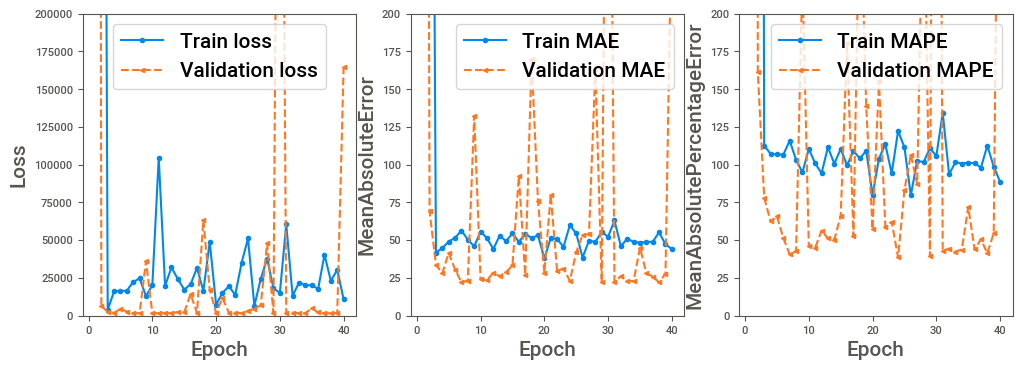

In [21]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.set_ylim(0,200_000)

ax = fig.add_subplot(1, 3, 2)
ax.plot(x_arr, hist['mae'], '-o', label='Train MAE')
ax.plot(x_arr, hist['val_mae'], '--<', label='Validation MAE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('MeanAbsoluteError', size=15)
ax.set_ylim(0,200)

ax = fig.add_subplot(1, 3, 3)
ax.plot(x_arr, hist['mape'], '-o', label='Train MAPE')
ax.plot(x_arr, hist['val_mape'], '--<', label='Validation MAPE')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('MeanAbsolutePercentageError', size=15)
ax.set_ylim(0,200)

plt.show()


# Random Forest - small featureset

max_depth=10,   # Default is 16  
min_examples=5,  # Default is 5  
num_trees=100,  # Default is 300  

## Preprocessing

In [22]:
df_engr_train.shape

(187002, 30)

In [23]:
df_engr_train.sample(3)

,rand_num,datasource,id,year,climate,building_class,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,electric_eui,fuel_eui,site_eui,source_eui,ghg_emissions_int,city_line,facility_type_consol,cooling_consol,heating_consol,wt_consol,is_residential,dryness,temp
18010,0.617470,calBEBP,6336072,2018.0,3B Warm - Dry (El Paso-TX),Commercial,Warehouse - Self-storage,65900.0,1980.0,NaN,NaN,NaN,NaN,NaN,NaN,Not Labeled,NaN,2.596126,0.792109,3.388235,8.983550,0.214173,"Sacramento, CA 95821",Industrial,NaN,NaN,NaN,0.0,Dry,Warm
230600,0.261092,nycOrdinance,3044640025,2015.0,4A Mixed - Humid (Baltimore-MD),Commercial,Education - Other classroom,58700.0,2009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,97.661564,216.326795,NaN,"Brooklyn, NY 11208",Office,NaN,NaN,NaN,0.0,Humid,Mixed
110700,0.438113,gainesville,146190,2011.0,2A Hot - Humid (Houston-TX),Residential,NaN,1890.0,1980.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,10.582569,NaN,NaN,NaN,NaN,"Gainesville, FL 32607",NaN,Central AC,NaN,NaN,1.0,Humid,Hot


In [24]:
# Columns of interest
exclude_cols = ['id', 'electric_eui', 'fuel_eui', 'source_eui', 'ghg_emissions_int',
                'rand_num', 'datasource', 'year', 'facility_type_consol',
                'heating', 'cooling', 'wall_type',
                'building_class', 'climate']

feature_cols = [col for col in df_engr_train.columns if col not in exclude_cols and col not in target_feature_cols]

target_col = 'site_eui'

# Preprocess
print("keep:", feature_cols, target_col)

# Drop dup buildings, keep most recent with target_col
train =  preprocess1(df_engr_train, target_col, keep_cols=feature_cols)
test = preprocess1(df_engr_test, target_col, keep_cols=feature_cols)

train.sample(5)

keep: ['facility_type', 'floor_area', 'year_built', 'roof_ceiling', 'window_glass_layers', 'window_glass_type', 'energy_star_label', 'energy_star_rating', 'city_line', 'cooling_consol', 'heating_consol', 'wt_consol', 'is_residential', 'dryness', 'temp'] site_eui
Shape (42274, 16)
Shape (18845, 16)


,facility_type,floor_area,year_built,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,city_line,cooling_consol,heating_consol,wt_consol,is_residential,dryness,temp,site_eui
22666,NaN,1740.0,1998.0,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,NaN,Central AC,NaN,NaN,1.0,Humid,Hot,32.711096
276,Multifamily - Uncategorized,248234.0,1985.0,Shingles,Single-pane,NaN,NaN,NaN,"Austin, TX 78723",NaN,NaN,NaN,1.0,Humid,Hot,31.159587
24467,Education - College or university,31355.0,1904.0,NaN,NaN,NaN,NaN,NaN,"New York, NY 10010",NaN,NaN,NaN,0.0,Humid,Mixed,84.368852
41863,Mixed Use - Predominantly Residential,258200.0,2017.0,NaN,NaN,NaN,NaN,82.0,"Washington, DC 20016",NaN,NaN,NaN,1.0,Humid,Mixed,48.460893
10161,Multifamily - Uncategorized,205408.0,2016.0,NaN,NaN,NaN,NaN,58.0,"Chicago, IL 60622",NaN,NaN,NaN,1.0,Humid,Cool,68.521612


In [25]:
# Define X and Y
X_train = train.drop(columns=[target_col]).copy()
y_train = train[[target_col]].copy()

X_test = test.drop(columns=[target_col]).copy()
y_test = test[[target_col]].copy()

print("train:", X_train.shape)
print("test:", X_test.shape)

train: (42274, 15)
test: (18845, 15)


In [26]:
X_train.head()

,facility_type,floor_area,year_built,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,city_line,cooling_consol,heating_consol,wt_consol,is_residential,dryness,temp
0,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,"Austin, TX 78704",NaN,NaN,NaN,1.0,Humid,Hot
1,Multifamily - Uncategorized,51195.0,1982.0,Shingles,Single-pane,NaN,NaN,NaN,"Austin, TX 78704",NaN,NaN,NaN,1.0,Humid,Hot
2,Multifamily - Uncategorized,5158.0,1996.0,Shingles,Double-pane,NaN,NaN,NaN,"Austin, TX 78704",NaN,NaN,NaN,1.0,Humid,Hot
3,Multifamily - Uncategorized,6600.0,1972.0,NaN,NaN,NaN,NaN,NaN,"Austin, TX 78704",NaN,NaN,NaN,1.0,Humid,Hot
4,Multifamily - Uncategorized,4300.0,1915.0,Built-up,NaN,Low-e,NaN,NaN,"Austin, TX 78704",NaN,NaN,NaN,1.0,Humid,Hot


In [27]:
y_train.head()

,site_eui
0,29.493681
1,39.017660
2,30.828877
3,33.249117
4,18.127962


## TFDT Small


### Preprocess

In [28]:
top_cols = ['facility_type', 'floor_area', 'year_built', 'is_residential', 
            'dryness', 'temp']
X_train_sm = X_train[top_cols].copy()
X_test_sm = X_test[top_cols].copy()
print(X_train_sm.shape)
X_train_sm.head()

(42274, 6)


,facility_type,floor_area,year_built,is_residential,dryness,temp
0,Multifamily - Uncategorized,160356.0,2013.0,1.0,Humid,Hot
1,Multifamily - Uncategorized,51195.0,1982.0,1.0,Humid,Hot
2,Multifamily - Uncategorized,5158.0,1996.0,1.0,Humid,Hot
3,Multifamily - Uncategorized,6600.0,1972.0,1.0,Humid,Hot
4,Multifamily - Uncategorized,4300.0,1915.0,1.0,Humid,Hot


In [29]:
train_sm = pd.concat([X_train_sm, y_train], axis=1)
test_sm = pd.concat([X_test_sm, y_test], axis=1)
train_sm

,facility_type,floor_area,year_built,is_residential,dryness,temp,site_eui
0,Multifamily - Uncategorized,160356.0,2013.0,1.0,Humid,Hot,29.493681
1,Multifamily - Uncategorized,51195.0,1982.0,1.0,Humid,Hot,39.017660
2,Multifamily - Uncategorized,5158.0,1996.0,1.0,Humid,Hot,30.828877
3,Multifamily - Uncategorized,6600.0,1972.0,1.0,Humid,Hot,33.249117
4,Multifamily - Uncategorized,4300.0,1915.0,1.0,Humid,Hot,18.127962
...,...,...,...,...,...,...,...
42269,Multifamily - Uncategorized,76847.0,1972.0,1.0,Humid,Mixed,50.536628
42270,Nursing Home,143000.0,1963.0,0.0,Humid,Mixed,96.295669
42271,Multifamily - Uncategorized,165875.0,2017.0,1.0,Humid,Mixed,72.223510
42272,Office - Uncategorized,69230.0,1961.0,0.0,Humid,Mixed,56.686502


#### Drop na rows

In [30]:
train_sm.isna().sum()

facility_type     12327
floor_area            0
year_built         2041
is_residential        0
dryness             479
temp                479
site_eui              0
dtype: int64

In [31]:
train_sm.dropna(inplace=True)
test_sm.dropna(inplace=True)
print(train_sm.shape, test_sm.shape)
train_sm.head()

(27572, 7) (9953, 7)


,facility_type,floor_area,year_built,is_residential,dryness,temp,site_eui
0,Multifamily - Uncategorized,160356.0,2013.0,1.0,Humid,Hot,29.493681
1,Multifamily - Uncategorized,51195.0,1982.0,1.0,Humid,Hot,39.017660
2,Multifamily - Uncategorized,5158.0,1996.0,1.0,Humid,Hot,30.828877
3,Multifamily - Uncategorized,6600.0,1972.0,1.0,Humid,Hot,33.249117
4,Multifamily - Uncategorized,4300.0,1915.0,1.0,Humid,Hot,18.127962


#### Create validation df

In [32]:
# Generate validation ds
validation_perc = 0.2
train_sm['rand'] = np.random.rand(train_sm.shape[0])
train_sm_core = train_sm[train_sm.rand > validation_perc].drop(columns='rand').copy()
train_sm_val  = train_sm[train_sm.rand <= validation_perc].drop(columns='rand').copy()

print(train_sm_core.shape, train_sm_val.shape)
train_sm_core

(21944, 7) (5628, 7)


,facility_type,floor_area,year_built,is_residential,dryness,temp,site_eui
0,Multifamily - Uncategorized,160356.0,2013.0,1.0,Humid,Hot,29.493681
2,Multifamily - Uncategorized,5158.0,1996.0,1.0,Humid,Hot,30.828877
3,Multifamily - Uncategorized,6600.0,1972.0,1.0,Humid,Hot,33.249117
4,Multifamily - Uncategorized,4300.0,1915.0,1.0,Humid,Hot,18.127962
5,Multifamily - Uncategorized,227074.0,1985.0,1.0,Humid,Hot,35.377377
...,...,...,...,...,...,...,...
42269,Multifamily - Uncategorized,76847.0,1972.0,1.0,Humid,Mixed,50.536628
42270,Nursing Home,143000.0,1963.0,0.0,Humid,Mixed,96.295669
42271,Multifamily - Uncategorized,165875.0,2017.0,1.0,Humid,Mixed,72.223510
42272,Office - Uncategorized,69230.0,1961.0,0.0,Humid,Mixed,56.686502


In [33]:
label = 'site_eui'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_sm_core, label=label, task=tfdf.keras.Task.REGRESSION)
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_sm_val, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_sm, label=label, task=tfdf.keras.Task.REGRESSION)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [34]:
train_ds

<PrefetchDataset element_spec=({'facility_type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'floor_area': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'year_built': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'is_residential': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'dryness': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'temp': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [35]:
# for e in train_ds:
#     print(e[0])

### Train

In [36]:
%set_cell_height 300

tf.keras.backend.clear_session()

# Specify the model.
model = tfdf.keras.RandomForestModel(
    task = tfdf.keras.Task.REGRESSION,
    temp_directory= path + 'output_ben/',  # Saves temp output (for model.save())
    verbose = 2,
    # discretize_numerical_features=True,  # This will reduce model performance, can't use for regression
    # allow_na_conditions=True,  # Allows model to learn NA
    max_depth=10,   # Default is 16
    min_examples=5,  # Default is 5
    num_trees=100,  # Default is 300
    random_seed=1000,
    name='Random_Forest_Regressor',
    )

model.compile(metrics=["mae", "mape"])

<IPython.core.display.Javascript object>

Use 2 thread(s) for training


In [37]:
# Train the model.
model.fit(x=train_ds)

Reading training dataset...
Training tensor examples:
Features: {'facility_type': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'floor_area': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'year_built': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, 'is_residential': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'dryness': <tf.Tensor 'data:0' shape=(None,) dtype=string>, 'temp': <tf.Tensor 'data_4:0' shape=(None,) dtype=string>}
Label: Tensor("data_6:0", shape=(None,), dtype=float64)
Weights: None
Normalized tensor features:
 {'facility_type': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data_1:0' shape=(None,) dtype=string>), 'floor_area': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast:0' shape=(None,) dtype=float32>), 'year_built': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<tf.Tensor 'Cast_1:0' shape=(None,) dtype=float32>), 'is_residential': SemanticTensor(semantic=<Semantic.NUMERICAL: 1>, tensor=<

[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 22
[INFO kernel.cc:423] Number of examples: 21944
[INFO data_spec_inference.cc:303] 14 item(s) have been pruned (i.e. they are considered out of dictionary) for the column facility_type (62 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:836] Training dataset:
Number of records: 21944
Number of columns: 7

Number of columns by type:
	NUMERICAL: 4 (57.1429%)
	CATEGORICAL: 3 (42.8571%)

Columns:

NUMERICAL: 4 (57.1429%)
	2: "floor_area" NUMERICAL mean:143944 min:500 max:4.69944e+06 sd:222708
	3: "is_residential" NUMERICAL mean:0.507519 min:0 max:1 sd:0.499943
	5: "year_built" NUMERICAL mean:1960.49 min:1649 max:2019 sd:36.8487
	6: "__LABEL" NUMERICAL mean:77.7921 min:1.01593 max:997.866 sd:66.7827

CATEGORICAL: 3 (42.8571%)
	0: "dryness" CATEGORICAL has-dict vocab-size:4 zero-ood-items most-frequent:"Humid"

Model trained in 0:00:02.455478
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [38]:
model.summary()

Model: "Random_Forest_Regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (6):
	dryness
	facility_type
	floor_area
	is_residential
	temp
	year_built

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.        "__LABEL"  8.528738 ################
    2. "is_residential"  6.978363 ############
    3.     "floor_area"  5.287174 ########
    4.     "year_built"  4.312361 ######
    5.        "dryness"  4.253538 ######
    6.           "temp"  3.033786 ####
    7.  "facility_type"  1.154285 

Variable Importance: NUM_AS_ROOT:
    1.  "facility_type" 48.000000 ################
    2.           "temp" 32.000000 ##########
    3.        "dryness" 14.000000 ####
    4.     "year_built"  4.000000 
    5. "is

### Evaluate

In [39]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=2)

In [40]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=4)

In [41]:
# Train metrics
model.compile(metrics=["mse", "mae", "mape"])
evaluation = model.evaluate(train_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

22/22 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - mse: 2629.8647 - mae: 29.2278 - mape: 96.2239

loss: 0.0000
mse: 2629.8647
mae: 29.2278
mape: 96.2239
RMSE: 51.282206915203545


In [42]:
# Validation
model.compile(metrics=["mse", "mae", "mape"])
evaluation = model.evaluate(val_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

6/6 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - mse: 3340.7107 - mae: 30.5170 - mape: 107.4560

loss: 0.0000
mse: 3340.7107
mae: 30.5170
mape: 107.4560
RMSE: 57.7988814196207


# Random Forest - large feature set
max_depth=16,   # Default is 16, small is 10  
min_examples=5,  # Default is 5, small is 5  
num_trees=500,  # Default is 300, small is 100  

### Preprocess

In [43]:
# Columns of interest
exclude_cols = ['id', 'electric_eui', 'fuel_eui', 'source_eui', 'ghg_emissions_int',
                'rand_num', 'datasource', 'year', 'facility_type_consol',
                'heating_consol', 'cooling_consol', 'wt_consol',
                'building_class', 'climate']

feature_cols = [col for col in df_engr_train.columns if col not in exclude_cols and col not in target_feature_cols]

target_col = 'site_eui'

# Preprocess
print("keep:", feature_cols, target_col)

# Drop dup buildings, keep most recent with target_col
train =  preprocess1(df_engr_train, target_col, keep_cols=feature_cols)
test = preprocess1(df_engr_test, target_col, keep_cols=feature_cols)

train.sample(5)

keep: ['facility_type', 'floor_area', 'year_built', 'heating', 'cooling', 'wall_type', 'roof_ceiling', 'window_glass_layers', 'window_glass_type', 'energy_star_label', 'energy_star_rating', 'city_line', 'is_residential', 'dryness', 'temp'] site_eui
Shape (42274, 16)
Shape (18845, 16)


,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,city_line,is_residential,dryness,temp,site_eui
20553,NaN,1274.0,2001.0,NaN,Central Air Conditioning,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,"Gainesville, FL 32601",1.0,Humid,Hot,56.279000
9890,Commercial - Other,86262.0,1948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Chicago, IL 60656",0.0,Humid,Cool,71.686471
24196,Multifamily - Uncategorized,412833.0,2005.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"New York, NY 10010",1.0,Humid,Mixed,98.000000
21221,NaN,975.0,1970.0,NaN,No cooling,NaN,Asphalt/fiberglass/other shingles,NaN,NaN,NaN,NaN,"Gainesville, FL 32601",1.0,Humid,Hot,106.634423
34433,Multifamily - Uncategorized,137100.0,1978.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,"Jamaica, NY 11432",1.0,Humid,Mixed,94.142077


In [44]:
# Generate validation ds
validation_perc = 0.2
train['rand'] = np.random.rand(train.shape[0])
train_core = train[train.rand > validation_perc].drop(columns='rand').copy()
train_val  = train[train.rand <= validation_perc].drop(columns='rand').copy()

print(train_core.shape, train_val.shape)
train_core

(33741, 16) (8533, 16)


,facility_type,floor_area,year_built,heating,cooling,wall_type,roof_ceiling,window_glass_layers,window_glass_type,energy_star_label,energy_star_rating,city_line,is_residential,dryness,temp,site_eui
0,Multifamily - Uncategorized,160356.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Austin, TX 78704",1.0,Humid,Hot,29.493681
1,Multifamily - Uncategorized,51195.0,1982.0,NaN,NaN,NaN,Shingles,Single-pane,NaN,NaN,NaN,"Austin, TX 78704",1.0,Humid,Hot,39.017660
2,Multifamily - Uncategorized,5158.0,1996.0,NaN,NaN,NaN,Shingles,Double-pane,NaN,NaN,NaN,"Austin, TX 78704",1.0,Humid,Hot,30.828877
3,Multifamily - Uncategorized,6600.0,1972.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Austin, TX 78704",1.0,Humid,Hot,33.249117
4,Multifamily - Uncategorized,4300.0,1915.0,NaN,NaN,NaN,Built-up,NaN,Low-e,NaN,NaN,"Austin, TX 78704",1.0,Humid,Hot,18.127962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42266,Multifamily - Uncategorized,547346.0,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.0,"Washington, DC 20001",1.0,Humid,Mixed,67.724015
42268,Office - Uncategorized,102429.0,1980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,"Washington, DC 20015",0.0,Humid,Mixed,48.058537
42269,Multifamily - Uncategorized,76847.0,1972.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,"Washington, DC 20001",1.0,Humid,Mixed,50.536628
42270,Nursing Home,143000.0,1963.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,"Washington, DC 20005",0.0,Humid,Mixed,96.295669


In [45]:
label = 'site_eui'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_core, label=label, task=tfdf.keras.Task.REGRESSION)
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    train_val, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test, label=label, task=tfdf.keras.Task.REGRESSION)

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core.py:2574: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [46]:
train_ds

<PrefetchDataset element_spec=({'facility_type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'floor_area': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'year_built': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'heating': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'cooling': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'wall_type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'roof_ceiling': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'window_glass_layers': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'window_glass_type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'energy_star_label': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'energy_star_rating': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'city_line': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'is_residential': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'dryness': TensorSpec(shape=(None,)

### Model

In [47]:
%set_cell_height 300

tf.keras.backend.clear_session()

# Specify the model.
model = tfdf.keras.RandomForestModel(
    task = tfdf.keras.Task.REGRESSION,
    temp_directory= path + 'output_ben/',
    verbose = 2,
    max_depth=16,
    min_examples=5,
    num_trees=500,
    random_seed=2000,
    name='Random_Forest_Regressor',
    )

model.compile(metrics=["mae", "mape"])

<IPython.core.display.Javascript object>

Use 2 thread(s) for training


In [48]:
# Train the model.
model.fit(x=train_ds)

Reading training dataset...
Training tensor examples:
Features: {'facility_type': <tf.Tensor 'data_5:0' shape=(None,) dtype=string>, 'floor_area': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'year_built': <tf.Tensor 'data_14:0' shape=(None,) dtype=float64>, 'heating': <tf.Tensor 'data_7:0' shape=(None,) dtype=string>, 'cooling': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'wall_type': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'roof_ceiling': <tf.Tensor 'data_9:0' shape=(None,) dtype=string>, 'window_glass_layers': <tf.Tensor 'data_12:0' shape=(None,) dtype=string>, 'window_glass_type': <tf.Tensor 'data_13:0' shape=(None,) dtype=string>, 'energy_star_label': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'energy_star_rating': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'city_line': <tf.Tensor 'data:0' shape=(None,) dtype=string>, 'is_residential': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'dryness': <tf.Tensor 'data_2:0' shape=(None,) dtype

[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 34
[INFO kernel.cc:423] Number of examples: 33741
[INFO data_spec_inference.cc:303] 765 item(s) have been pruned (i.e. they are considered out of dictionary) for the column city_line (670 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:303] 3 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cooling (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:303] 13 item(s) have been pruned (i.e. they are considered out of dictionary) for the column facility_type (66 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:303] 5 item(s) have been pruned (i.e. they are considered out of dictionary) for the column heating (1 item(s) left) because min_value_count=

Model trained in 0:11:41.753253
Compiling model...
Model compiled.


In [49]:
model.summary()

Model: "Random_Forest_Regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (15):
	city_line
	cooling
	dryness
	energy_star_label
	energy_star_rating
	facility_type
	floor_area
	heating
	is_residential
	roof_ceiling
	temp
	wall_type
	window_glass_layers
	window_glass_type
	year_built

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.   "window_glass_type" 13.344754 ################
    2.             "__LABEL" 13.344754 ################
    3.             "heating" 13.343849 ###############
    4. "window_glass_layers" 13.343293 ###############
    5.           "wall_type" 13.317810 ###############
    6.             "cooling" 13.265610 ###############
    7.   "energy_star_label" 13.241358 #######

### Evaluate

In [50]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0, max_depth=4)

In [51]:
# Train metrics
model.compile(metrics=["mse", "mae", "mape"])
evaluation = model.evaluate(train_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

34/34 [==============================] - 8s 221ms/step - loss: 0.0000e+00 - mse: 855.1793 - mae: 14.1051 - mape: 43.6796

loss: 0.0000
mse: 855.1793
mae: 14.1051
mape: 43.6796
RMSE: 29.24344920301062


In [52]:
# Validation
model.compile(metrics=["mse", "mae", "mape"])
evaluation = model.evaluate(val_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

9/9 [==============================] - 2s 212ms/step - loss: 0.0000e+00 - mse: 1635.8453 - mae: 19.5489 - mape: 70.4686

loss: 0.0000
mse: 1635.8453
mae: 19.5489
mape: 70.4686
RMSE: 40.44558488777314


### Complicated Model - hyperparameter tuning

In [53]:
%set_cell_height 300

tf.keras.backend.clear_session()

# Specify the model.
model = tfdf.keras.RandomForestModel(
    task = tfdf.keras.Task.REGRESSION,
    temp_directory= path + 'output_ben/',     # Saves temp output (for model.save())
    verbose = 2,
    allow_na_conditions=True,                   # Allows model to learn NA
    max_depth=25,
    min_examples=3,
    num_trees=300,
    random_seed=3000,                           # small is 1000, large is 2000
    name='Random_Forest_Regressor',
    )

model.compile(metrics=["mae", "mape"])

<IPython.core.display.Javascript object>

Use 2 thread(s) for training


In [54]:
# Train the model.
model.fit(x=train_ds)

Reading training dataset...
Training tensor examples:
Features: {'facility_type': <tf.Tensor 'data_5:0' shape=(None,) dtype=string>, 'floor_area': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'year_built': <tf.Tensor 'data_14:0' shape=(None,) dtype=float64>, 'heating': <tf.Tensor 'data_7:0' shape=(None,) dtype=string>, 'cooling': <tf.Tensor 'data_1:0' shape=(None,) dtype=string>, 'wall_type': <tf.Tensor 'data_11:0' shape=(None,) dtype=string>, 'roof_ceiling': <tf.Tensor 'data_9:0' shape=(None,) dtype=string>, 'window_glass_layers': <tf.Tensor 'data_12:0' shape=(None,) dtype=string>, 'window_glass_type': <tf.Tensor 'data_13:0' shape=(None,) dtype=string>, 'energy_star_label': <tf.Tensor 'data_3:0' shape=(None,) dtype=string>, 'energy_star_rating': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'city_line': <tf.Tensor 'data:0' shape=(None,) dtype=string>, 'is_residential': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'dryness': <tf.Tensor 'data_2:0' shape=(None,) dtype

[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 34
[INFO kernel.cc:423] Number of examples: 33741
[INFO data_spec_inference.cc:303] 765 item(s) have been pruned (i.e. they are considered out of dictionary) for the column city_line (670 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:303] 3 item(s) have been pruned (i.e. they are considered out of dictionary) for the column cooling (4 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:303] 13 item(s) have been pruned (i.e. they are considered out of dictionary) for the column facility_type (66 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO data_spec_inference.cc:303] 5 item(s) have been pruned (i.e. they are considered out of dictionary) for the column heating (1 item(s) left) because min_value_count=

Model trained in 0:07:51.796706
Compiling model...
Model compiled.


In [55]:
model.summary()

Model: "Random_Forest_Regressor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (15):
	city_line
	cooling
	dryness
	energy_star_label
	energy_star_rating
	facility_type
	floor_area
	heating
	is_residential
	roof_ceiling
	temp
	wall_type
	window_glass_layers
	window_glass_type
	year_built

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.             "__LABEL" 17.915627 ################
    2.   "window_glass_type" 17.912303 ###############
    3.             "heating" 17.895801 ###############
    4. "window_glass_layers" 17.675948 ###############
    5.           "wall_type" 17.538713 ###############
    6.   "energy_star_label" 16.417282 ##############
    7.      "is_residential" 16.230085 #########

### Evaluate

In [56]:
# Train metrics
model.compile(metrics=["mse", "mae", "mape"])
evaluation = model.evaluate(train_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

34/34 [==============================] - 23s 671ms/step - loss: 0.0000e+00 - mse: 540.2357 - mae: 10.4744 - mape: 32.1941

loss: 0.0000
mse: 540.2357
mae: 10.4744
mape: 32.1941
RMSE: 23.24297004985123


In [57]:
# Val metrics
model.compile(metrics=["mse", "mae", "mape"])
evaluation = model.evaluate(val_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

9/9 [==============================] - 6s 652ms/step - loss: 0.0000e+00 - mse: 1648.8820 - mae: 19.6297 - mape: 69.7531

loss: 0.0000
mse: 1648.8820
mae: 19.6297
mape: 69.7531
RMSE: 40.60642754549841


In [58]:
# Test metrics
model.compile(metrics=["mse", "mae", "mape"])
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

19/19 [==============================] - 13s 665ms/step - loss: 0.0000e+00 - mse: 1218.7836 - mae: 16.1808 - mape: 47.1652

loss: 0.0000
mse: 1218.7836
mae: 16.1808
mape: 47.1652
RMSE: 34.9110808961272
